<h1> Exercice QM Robin Masliah </h1>

### Données
* **datetime** : date et heure du relevé 
* **season** : 1 = printemps , 2 = été, 3 = automne, 4 = hiver 
* **holiday** : indique si le jour est un jour de vacances scolaires  
* **workingday** : indique si le jour est travaillé (ni week­end ni vacances) 
* **weather** : 1: Dégagé à nuageux, 2 : Brouillard, 3 : Légère pluie ou neige, 4 : Fortes averses ou neiges 
* **temp** : température en degrés Celsius 
* **atemp** : température ressentie en degrés Celsius 
* **humidity** : taux d’humidité 
* **windspeed** : vitesse du vent 
* **casual** : nombre de locations d’usagers non abonnés 
* **registered** : nombre de locations d’usagers abonnés 
* **count** : nombre total de locations de vélos

### Objectif
* Prédire le nombre de vélos loués par heure.


In [70]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import re

from sqlalchemy import create_engine

import sklearn
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data.csv', sep=',', parse_dates=True)

## Analyse préliminaire des données

In [3]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
# Variable count (nombre de vélos loués par heure) : {Min = 1, Max = 977, Variance = 181, Moyenne = 192}
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


* Ne semble pas avoir de valeurs abérrantes.

In [5]:
# Fonction pour dissocier la date de l'heure
def split_it(year):
    return re.findall('([^\s]+)', year)

In [6]:
# Tranformation de la colonne datetime en deux colonnes distinctes heure et date
df['datetime'] = df['datetime'].apply(lambda x: split_it(x))

df['date'] = 0
df['heure'] = 0

for i in range(0, len(df['datetime'])):
    df['date'][i] = df['datetime'][i][0]

for i in range(0, len(df['datetime'])):
    df['heure'][i] = df['datetime'][i][1]

del df['datetime']

In [7]:
# Création d'un index date
df["date"] = pd.to_datetime(df["date"], errors="ignore", format="%Y/%m/%d")
df.set_index('date', inplace=True)

In [8]:
df_ts = df['count']

In [9]:
# Création des moyennes hebdomadaires
df_ts = df_ts.resample('W').mean()
df_ts = df_ts.dropna()

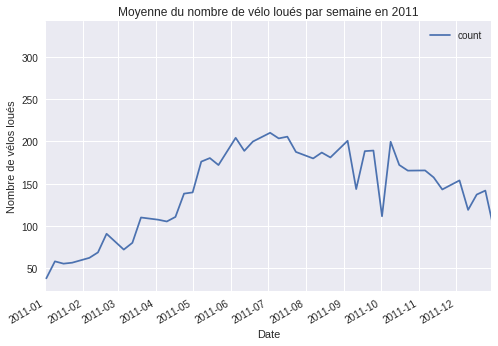

In [10]:
# Année 2011
ax = df_ts.plot()
ax.set_xlim(pd.Timestamp('2011-01-01'), pd.Timestamp('2011-12-30'))

plt.xlabel('Date')
plt.ylabel('Nombre de vélos loués')
plt.title("Moyenne du nombre de vélo loués par semaine en 2011")

plt.axis()
plt.legend()
plt.show()

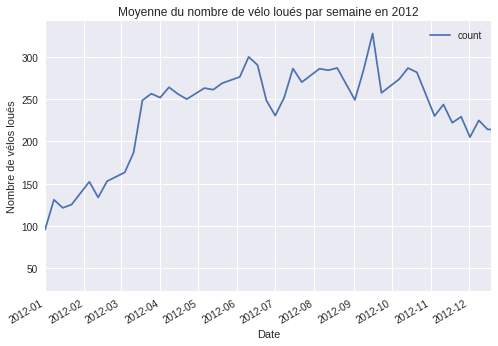

In [11]:
# Année 2012
ax = df_ts.plot()
ax.set_xlim(pd.Timestamp('2012-01-01'), pd.Timestamp('2012-12-19'))

plt.xlabel('Date')
plt.ylabel('Nombre de vélos loués')
plt.title("Moyenne du nombre de vélo loués par semaine en 2012")

plt.axis()
plt.legend()
plt.show()

- Il y a moins de vélos loués en hiver (de janvier à mars) que tout le reste de l'année.

In [12]:
df1 = df.copy()

In [13]:
df2 = df1[['count', 'heure']]
df2.set_index('heure', inplace=True)
# Création des moyennes de vélos loués par heure dans une journée.
df2 = df2.groupby(['heure'])['count'].mean()
df2 = df2.dropna()

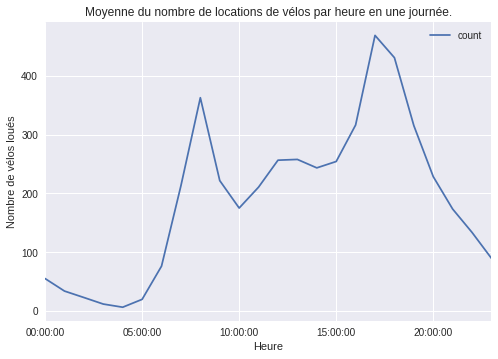

In [14]:
# Moyenne du nombre de locations de vélos par heure en une journée.
df2.plot()
plt.xlabel('Heure')
plt.ylabel('Nombre de vélos loués')
plt.title("Moyenne du nombre de locations de vélos par heure en une journée.")

plt.axis()
plt.legend()
plt.show()

- Nous pouvons voir sur ce graphique que la location de vélos est moindre entre minuit et 5h du matin.

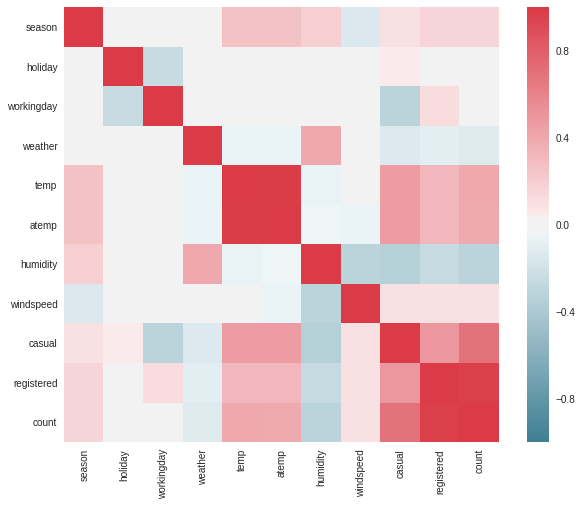

In [15]:
# Etude des corrélations entre les features
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

- Les corrélations les plus importantes sont les suivantes :
    * température et température ressentie
    * Casual, Registered et count très logiquement étant donné que **count = (registered + casual)**
    * La température (temp et atemp) sont corrélées avec casual, registered et count. Mais surtout avec casual. Le froid dissuade les emprunteurs occasionnels.

In [16]:
# Changement du format heure pour le rendre exploitable par le modèle
df.heure = df.heure.replace({"00:00:00": "0", "01:00:00": "1", "02:00:00": "2",
                             "03:00:00": "3", "04:00:00": "4", "05:00:00": "5",
                             "06:00:00": "6", "07:00:00": "7", "08:00:00": "8",
                             "09:00:00": "9", "10:00:00": "10", "11:00:00": "11",
                             "12:00:00": "12", "13:00:00": "13", "14:00:00": "14",
                             "15:00:00": "15", "16:00:00": "16", "17:00:00": "17",
                             "18:00:00": "18", "19:00:00": "19", "20:00:00": "20",
                             "21:00:00": "21", "22:00:00": "22", "23:00:00": "23"})

In [17]:
dft = df.copy()
dft['heure'].head()

date
2011-01-01    0
2011-01-01    1
2011-01-01    2
2011-01-01    3
2011-01-01    4
Name: heure, dtype: object

In [18]:
# SQL engine pour pouvoir explorer les données à l'oeil nu rapidement à titre observatoire.
engine = create_engine('sqlite:///:memory:')
dft.to_sql('table', engine)
pd.read_sql_table('table', engine)
pd.read_sql_query('select * from "table" limit 5', con=engine)

,date,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,heure
0,2011-01-01 00:00:00.000000,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
1,2011-01-01 00:00:00.000000,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2,2011-01-01 00:00:00.000000,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
3,2011-01-01 00:00:00.000000,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
4,2011-01-01 00:00:00.000000,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


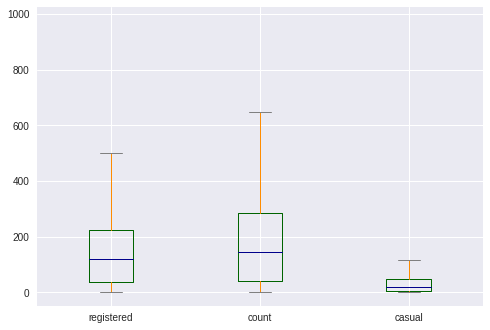

In [93]:
color = dict(boxes='DarkGreen', whiskers='DarkOrange',
             medians='DarkBlue', caps='Gray')
df_box_plot = df[['registered', 'count', 'casual']]
df_box_plot.plot.box(color=color, sym='r+')

* La réponse à la variable count à prédire se trouve dans les features registered et casual. C'est pourquoi je supprime ces deux colonnes pour ne pas les traiter avec le modèle.

   season   count
0       1  312498
1       2  588282
2       3  640662
3       4  544034


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f15f64d6f60>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f15f64bf4a8>], dtype=object)

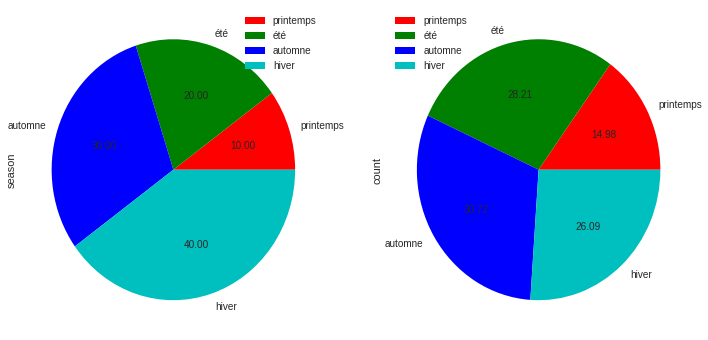

In [20]:
pie = pd.read_sql_query(
    'select distinct(season), sum(count) as count from "table" group by season', con=engine)
print(pie)

pie.plot.pie(labels=['printemps', 'été', 'automne', 'hiver'], subplots=True, colors=['r', 'g', 'b', 'c'],
             autopct='%.2f', fontsize=10, figsize=(12, 6))

- La saison ne semble pas avoir d'influence sur le nombre d'emprunt de vélos.

In [21]:
# Remplacement des features température réelle et ressentie par la moyenne entre les deux (compromis)
df['temperature'] = ((df['temp'] + df['atemp']) / 2)
del df['temp']
del df['atemp']

In [22]:
# Sauvegarde df pour le réutiliser facilement
dft = df.copy()

In [34]:
# Split des data
y = dft['count']
X = dft.copy()
del X['count']
del X['registered']
del X['casual']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)

In [36]:
# Dataframe final à destination du modèle
X.head()

,season,holiday,workingday,weather,humidity,windspeed,heure,temperature
date,,,,,,,,
2011-01-01,1,0,0,1,81,0.0,0,12.1175
2011-01-01,1,0,0,1,80,0.0,1,11.3275
2011-01-01,1,0,0,1,80,0.0,2,11.3275
2011-01-01,1,0,0,1,75,0.0,3,12.1175
2011-01-01,1,0,0,1,75,0.0,4,12.1175


### Test des distributions
Etapes du test d’indépendance du khi-carré
Pour résumer, les principales étapes du test d’indépendance du Khi-carré sont :

1) Si ce n’est pas déjà fait, distribuer la population statistique dans un tableau à deux caractères (âges et sexes) où les modalités et/ou les valeurs sont regroupées par catégories. Dans notre cas nous avons les sexes des individus.

2) Calculer le khi-carré dans l’hypothèse d’indépendance des deux caractères : 

$$ \chi_{calcul}^{2} = \sum_{i = 1}^{n} \sum_{j = 1}^{e} \frac{(n_{i,j}-e_{i,j})^{2}}{e_{i,j}} $$

3) Calculer le nombre de degrés de liberté par la formule :
(Nombre de lignes - 1) x (Nombre de colonnes – 1) 

4) Définir une probabilité d’erreur (en pratique 5%, 1% ou 1 pour mille)

5) Utiliser le nombre de degrés de liberté et la probabilité d’erreur pour déterminer le khi-carré théorique à partir de la table fournie.

6) comparer la valeur khi-carré calculée avec la valeur khi-carrée théorique (issue de la table) et appliquer la règle suivante : 
* Si le khi-carré calculé est inférieur au khi-carré théorique : indépendance 
* Si le khi-carré calculé est supérieur au khi-carré théorique : dépendance

## Modèle : Random Forest Regressor

In [83]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [84]:
importances = rf.feature_importances_
std = np.std([rf.feature_importances_ for rf in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Affichage dans l'ordre des features importantes
print("Features :")

for i in range(0, len(X_train.columns)):
    print(i + 1, X_train.columns[i])

print("\n")
print("Features importances rankées:")
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" %
          (f + 1, indices[f] + 1, importances[indices[f]]))

Features :
1 season
2 holiday
3 workingday
4 weather
5 humidity
6 windspeed
7 heure
8 temperature


Features importances rankées:
1. feature 7 (0.594034)
2. feature 8 (0.154388)
3. feature 3 (0.079374)
4. feature 5 (0.068939)
5. feature 1 (0.040962)
6. feature 6 (0.038816)
7. feature 4 (0.020180)
8. feature 2 (0.003308)


In [74]:
# Random forest et features importance

parameters = {'n_estimators': [1, 2, 10, 20, 30],
              'max_depth': [1, 2, 5, 8, 10, 14, 18, 20],
              'bootstrap': [True],
              'random_state': [1, 2, 3]
              }

rf = RandomForestRegressor()
clf = GridSearchCV(rf, parameters, n_jobs=-1, verbose=1)
clf.fit(X_train, y_train)
scores = cross_val_score(clf, X_train, y_train, cv=10)
y_pred = clf.predict(X_test)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done 262 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   18.1s finished


Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   18.3s finished


Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 353 out of 360 | elapsed:   15.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   16.4s finished


Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done 262 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   16.7s finished


Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   16.7s finished


Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   16.6s finished


Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done 262 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   17.0s finished


Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 353 out of 360 | elapsed:   16.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   16.9s finished


Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done 262 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   19.4s finished


Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done 254 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   18.5s finished


Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   16.9s finished


In [85]:
print(clf.best_params_)
print('Meilleur score : ', clf.best_score_)

{'bootstrap': True, 'max_depth': 14, 'n_estimators': 30, 'random_state': 3}
Meilleur score :  0.833216249454


### Evaluation du modèle

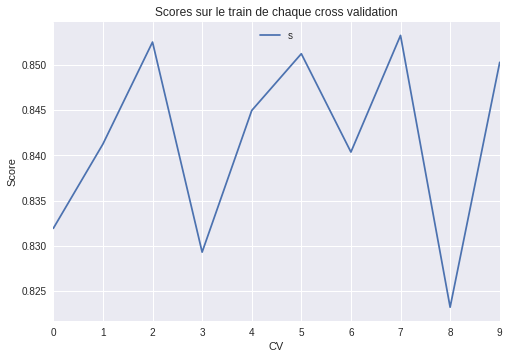

In [79]:
scores = pd.DataFrame(scores)
scores.plot()

plt.xlabel('CV')
plt.ylabel('Score')
plt.title("Scores sur le train de chaque cross validation")

plt.axis()
plt.legend("scores", loc='upper center')
plt.show()

In [87]:
y_pred = pd.DataFrame(y_pred)

In [88]:
print("5 premiers y prédits : ")
print(y_pred.head(20))
print("\n")
print("5 premiers y vrais : ")
print(y_test.head(20))

5 premiers y prédits : 
             0
0   179.074225
1    26.600000
2   155.304444
3   180.976975
4   143.417976
5   139.844444
6   152.231592
7   432.379654
8   622.889236
9   107.870753
10    7.428083
11   19.058878
12  273.295838
13   62.668889
14  264.087041
15   14.514045
16   76.001420
17  106.938987
18  182.952509
19   13.220856


5 premiers y vrais : 
date
2011-07-19    127
2012-01-16     13
2011-12-11    163
2012-08-15    233
2012-06-15    222
2012-11-03    166
2011-12-16    144
2011-07-03    376
2012-11-07    601
2011-01-02     53
2011-11-06      6
2012-06-18     14
2011-07-07    209
2011-08-14     62
2011-04-04    139
2011-09-11      9
2012-09-09     96
2011-03-08     98
2011-09-10    230
2011-07-17     12
Name: count, dtype: int64


### R-carré

R-carré est une mesure statistique de la proximité des données par rapport à la droite de régression ajustée. Il est également connu comme le coefficient de détermination, ou le coefficient de détermination multiple pour la régression multiple.

La définition de R-carré est assez simple; c'est le pourcentage de la variance de la variable de réponse qui est expliqué par un modèle linéaire. Où :

R-carré = Variance expliquée / Variance totale

R-carré est toujours entre 0 et 100%:

* 0% indique que le modèle n'explique pas la variabilité des données de réponse autour de sa moyenne.
* 100% indique que le modèle explique toute la variabilité des données de réponse autour de sa moyenne.

En général, plus le R-carré est élevé, plus le modèle correspond à vos données. 

In [91]:
print('Le coefficient de détermination :')
r2_score(y_test, y_pred, sample_weight=None, multioutput='uniform_average')

Le coefficient de détermination :


0.84328766118324872